<a href="https://colab.research.google.com/github/heejvely/NLP_models/blob/main/Transformer_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 코드 참조: https://paul-hyun.github.io/transformer-03/

Transformer 구현한기_2의 Transformer 클래스를 이용하여 NAver 영화리뷰 감정분석 분류 모델 클래스 정의

0. Imports

In [1]:
# sentencepiece import
!pip install sentencepiece
!pip install wget

     |████████████████████████████████| 1.2 MB 4.2 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=f9236dfa6939a90773ec435c363cd66e3eaa80a0f4b389e21f37222e5b58c797
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# gpu 설정
!nvidia-smi

Fri Dec 31 09:30:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1. Vocab

sentencepiece를 활용해 만든 vocab을 이용해 텍스트를 입력 tensor로 변경

In [4]:
import sentencepiece as spm
# vocab loading
vocab_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

* SentencePieceProcessor class 참고
: https://github.com/google/sentencepiece/blob/master/doc/api.md

In [5]:
help(spm.SentencePieceProcessor)

Help on class SentencePieceProcessor in module sentencepiece:

class SentencePieceProcessor(builtins.object)
 |  SentencePieceProcessor(model_file=None, model_proto=None, out_type=<class 'int'>, add_bos=False, add_eos=False, reverse=False, enable_sampling=False, nbest_size=-1, alpha=0.1)
 |  
 |  Methods defined here:
 |  
 |  Decode(self, input)
 |      Decode processed id or token sequences.
 |  
 |  DecodeIds = DecodeIdsWithCheck(self, ids)
 |  
 |  DecodeIdsAsSerializedProto = DecodeIdsAsSerializedProtoWithCheck(self, ids)
 |  
 |  DecodeIdsAsSerializedProtoWithCheck(self, ids)
 |  
 |  DecodeIdsWithCheck(self, ids)
 |  
 |  DecodePieces(self, pieces)
 |  
 |  DecodePiecesAsSerializedProto(self, pieces)
 |  
 |  Detokenize = Decode(self, input)
 |  
 |  Encode(self, input, out_type=None, add_bos=None, add_eos=None, reverse=None, enable_sampling=None, nbest_size=None, alpha=None)
 |      Encode text input to segmented ids or tokens.
 |      
 |      Args:
 |      input: input string

2. Config

설정을 json 형태로 저장하고, 이를 읽어서 처리하는 간단한 클래스

In [5]:
"""configuration json을 읽어들이는 class"""
class Config(dict):
  __getattr__ = dict.__getitem__
  __setarrt__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

In [6]:
config = Config({
    'n_enc_vocab':len(vocab),
    'n_dec_vocab':len(vocab),
    'n_enc_seq':256,
    'n_dec_seq':256,
    'n_layer':6,
    'd_hidn':256,
    'i_pad':0,
    'd_ff':1024,
    'n_head':4,
    'd_head':64,
    'dropout':0.1,
    'layer_norm_epsilon':1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


3. Common Class

Transformer 구현하기_1.ipynb 에서 구현한 'Position Embedding','Multi-Head Attention','Feed Forward'의 코드

#### Position Encoding

Position Embedding의 초기 값을 구하는 함수
1. 각 position별 hidden index별 angle 값을 구합니다.
2. hidden 짝수 index의 angle값의 sin값을 구합니다.
3. hidden 홀수 index의 angle값의 cos값을 구합니다.

In [7]:
"""sinusoid position encoding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn):
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])  # 1. 각 position별 hidden index별 angle 값을 구합니다.
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])                         # 2. hidden 짝수 index의 angle값의 sin값을 구합니다.
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])                         # 3. hidden 홀수 index의 angle값의 cos값을 구합니다.

  return sinusoid_table

#### Attention Pad Mask

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수

1. K의 값 중에 Pad인 부분을 True로 변경합니다.(나머지는 False)
2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.

In [8]:
"""attention pad mask"""
def get_attn_pad_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attn_mask = seq_k.data.eq(i_pad)                                              # 1. K의 값 중에 Pad인 부분을 True로 변경합니다.(나머지는 False)
  pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)       # 2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.
  return pad_attn_mask

#### Attention Decoder Mask

Decoder의 'Masked Multi Head Attention'에서 사용할 Mask를 구하는 함수입니다.

현재 단어와 이전 단어는 볼 수 있고 다음 단어는 볼 수 없도록 Masking 합니다.

1. 모든 값이 1인 Q-len, K-leb 테이블을 생성합니다.
2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.

In [9]:
"""attention decoder mask"""
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1)) # 1. 모든 값이 1인 Q-len, K-leb 테이블을 생성합니다.
  subsequent_mask = subsequent_mask.triu(diagonal=1)                                                 # 2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.
  return subsequent_mask

#### Scaled Dot Product Attention

Scaled Dot Product Attention을 구하는 클래스

1. Q * K.transpose를 구합니다.
2. K-dimention에 루트를 취한 값으로 나눠 줍니다.
3. Mask를 적용합니다.
4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

In [10]:
"""scale dot product attention"""
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.dropout= nn.Dropout(config.dropout)
    self.scale = 1 / (self.config.d_head ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    scores = torch.matmul(Q, K.transpose(-1, -2))     # 1. Q * K.transpose를 구합니다.
    scores = scores.mul_(self.scale)                   # 2. K-dimention에 루트를 취한 값으로 나눠 줍니다.
    scores.masked_fill_(attn_mask, -1e9)              # 3. Mask를 적용합니다.

    attn_prob = nn.Softmax(dim= -1)(scores)           # 4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
    attn_prob = self.dropout(attn_prob)               # 5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

    context = torch.matmul(attn_prob, V)

    return context, attn_prob

#### Multi-Head Attention

Multi-Head Attention을 구하는 클래스

1. Q * W_Q를 한 후 multi-head로 나눕니다.
2. K * W_K를 한 후 multi-head로 나눕니다.
3. V * W_V를 한 후 multi-head로 나눕니다.
4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
5. 여러 개의 head를 1개로 합칩니다.
6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.

In [11]:
"""multi head attention"""
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, Q, K, V, attn_mask):
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 1. Q * W_Q를 한 후 multi-head로 나눕니다.
    k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 2. K * W_K를 한 후 multi-head로 나눕니다.
    v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 3. V * W_V를 한 후 multi-head로 나눕니다.

    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)                                             # 4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)    # 5. 여러 개의 head를 1개로 합칩니다.
    output = self.linear(context)                                                                                   # 6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.
    output = self.dropout(output)
    
    return output, attn_prob


#### Feed Forward

FeedForward를 처리하는 클래스입니다.

1. Linear를 실행하여 shape을 d_ff(hidden * 4)크기로 키웁니다.
2. activation 함수(relu or gelu)를 실행합니다.
3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.

In [12]:
"""feed forward"""
class PoswiseFeedForwardNet(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.conv1 = nn.Conv1d(in_channels = self.config.d_hidn, out_channels = self.config.d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels = self.config.d_ff, out_channels = self.config.d_hidn, kernel_size=1)
    self.active = F.gelu
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, inputs):
    output = self.conv1(inputs.transpose(1, 2))     # 1. Linear를 실행하여 shape을 d_ff(hidden * 4)크기로 키웁니다.
    output = self.active(output)                    # 2. activation 함수(relu or gelu)를 실행합니다.

    output = self.conv2(output).transpose(1, 2)     # 3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.
    output = self.dropout(output)

    return output

4. Encoder

#### Encoder layer

Encoder에서 루프를 돌며 처리할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행

1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.
3. 2번의 결과를 입력으로 Feed Forward를 실행합니다.
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

In [13]:
"""encoder layer"""
class EncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

  def forward(self, inputs, attn_mask):
    attn_outputs, attn_prob = self.self_attn(inputs, inputs, inputs,attn_mask)    # 1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
    attn_outputs = self.layer_norm1(inputs + attn_outputs)                        # 2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.

    ffn_outputs = self.pos_ffn(attn_outputs)                                      # 3. 2번의 결과를 입력으로 Feed Forward를 실행합니다.
    ffn_outputs = self.layer_norm2(ffn_outputs + attn_outputs)                    # 4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

    return ffn_outputs, attn_prob

#### Encoder
Encoder 클래스

1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다.
3. 입력에 대한 attention pad mask를 구합니다.
4. for 루프를 돌며 각 layer를 실행합니다. layer의 입력은 이전 layer의 출력 값입니다.

In [14]:
"""encoder"""
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
    sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

    self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

  def forward(self, inputs):
    # 1. 입력에 대한 Position 값을 구합니다.
    positions = torch.arange(inputs.size(1), device = inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
    pos_mask = inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    outputs = self.enc_emb(inputs) + self.pos_emb(positions)          # 2. Input Embedding과 Position Embedding을 구한 후 더합니다.

    attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)  # 3. 입력에 대한 attention pad mask를 구합니다.

    attn_probs = []
    for layer in self.layers:
      outputs, attn_prob = layer(outputs, attn_mask)                  # 4. for 루프를 돌며 각 layer를 실행합니다. layer의 입력은 이전 layer의 출력 값입니다.
      attn_probs.append(attn_prob)

    return outputs, attn_probs

5. Decoder

#### Decoder Layer

Decoder에서 루프를 돌며 처리할 수 있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행

1. Multi-Head Attention을 수행합니다.
- Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.
3. Encoder-Decoder Multi-Head Attention을 수행합니다.
- Q: 2번의 결과
- K, V: Encoder 결과
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.
5. 4번의 결과를 입력으로 FeedForward를 실행합니다.
6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

In [15]:
"""decoder layer"""
class DecoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
    self.dec_enc_attn = MultiHeadAttention(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

  def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
    self_attn_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)      # 1. Multi-Head Attention을 수행합니다. - Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
    self_attn_outputs = self.layer_norm1(dec_inputs + self_attn_outputs)                                        # 2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.

    # 3. Encoder-Decoder Multi-Head Attention을 수행합니다.
    # - Q: 2번의 결과
    # - K, V: Encoder 결과
    dec_enc_attn_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_attn_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
    dec_enc_attn_outputs = self.layer_norm2(self_attn_outputs + dec_enc_attn_outputs)                           # 4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

    ffn_outputs = self.pos_ffn(dec_enc_attn_outputs)                                                            # 5. 4번의 결과를 입력으로 FeedForward를 실행합니다.
    ffn_outputs = self.layer_norm3(dec_enc_attn_outputs + ffn_outputs)                                          # 6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.
    
    return ffn_outputs, self_attn_prob, dec_enc_attn_prob

#### Decoder
Decoder 클래스

1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다.
3. 입력에 대한 attention pad mask를 구합니다.
4. 입력에 대한 decoder attention mask를 구합니다.
5. attention pad mask와 decoder attention mask 중 1곳이라도 mask 되어 있는 부분이 mask 되도록 attention mask를 구합니다.
6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다.
7. for 루프를 돌며 각 layer를 실행합니다.
- layer의 입력은 이전 layer의 출력 값입니다.

In [16]:
"""decoder"""
class Decoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
    sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze = True)

    self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])

  def forward(self, dec_inputs, enc_inputs, enc_outputs):
    # 1. 입력에 대한 Position 값을 구합니다.
    positions = torch.arange(dec_inputs.size(1), device = dec_inputs.device, dtype = dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous()+ 1
    pos_mask = dec_inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)                    # 2. Input Embedding과 Position Embedding을 구한 후 더합니다.

    dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)    # 3. 입력에 대한 attention pad mask를 구합니다.
    dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)                           # 4. 입력에 대한 decoder attention mask를 구합니다.
    dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)       # 5. attention pad mask와 decoder attention mask 중 1곳이라도 mask 되어 있는 부분이 mask 되도록 attention mask를 구합니다.
    dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)    # 6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다.

    self_attn_probs, dec_enc_attn_probs = [], []
    # 7. for 루프를 돌며 각 layer를 실행합니다.
    # - layer의 입력은 이전 layer의 출력 값입니다.
    for layer in self.layers:
      dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
      self_attn_probs.append(self_attn_prob)
      dec_enc_attn_probs.append(dec_enc_attn_prob)
    return dec_outputs, self_attn_probs, dec_enc_attn_probs

6. Transformer

Transformer 클래스

1. Encoder Input을 입력으로 Encoder를 실행합니다.
2. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다.

In [17]:
"""transformer"""
class Transformer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.encoder = Encoder(self.config)
    self.decoder = Decoder(self.config)

  def forward(self, enc_inputs, dec_inputs):
    enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)                                                 # 1. Encoder Input을 입력으로 Encoder를 실행합니다.
    dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)    # 2. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다.
    return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# 1. Model

Transforemr 클래스를 이용하여 Naver 영화리뷰 감정분석 분류 모델 클래스를 정의

1. Encoder input과 Decoder inurt을 입력으로 Transforemr 모델을 실행합니다.
2. Transformer 출력의 max 값을 구합니다.
3. Linear를 실행하여 최종 예측 결과를 만듭니다.

In [18]:
"""naver movie classifiaction"""
class MovieClassification(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.transformer = Transformer(self.config)
    self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)

  def forward(self, enc_inputs, dec_inputs):
    dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)  # 1. Encoder input과 Decoder inurt을 입력으로 Transforemr 모델을 실행합니다.
    dec_outputs, _ = torch.max(dec_outputs, dim=1)                                                                        # 2. Transformer 출력의 max 값을 구합니다.
    logits = self.projection(dec_outputs)                                                                                  # 3. Linear를 실행하여 최종 예측 결과를 만듭니다.

    return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# 2. Dataset

#### Dataset

Naber 영화리뷰 감정분석 데이터 셋

1. 입력 파일로부터 'label'을 읽어 들입니다.
2. 입력 파일로부터 'doc'token을 읽어 숫자(token id)로 변경합니다.
3. Decoder 입력은 '[BOS]'로 고정합니다.

In [19]:
"""영화 분류 데이터셋"""
class MovieDataSet(torch.utils.data.Dataset):
  def __init__(self, vocab, infile):
    self.vocab = vocab
    self.labels = []
    self.sentences = []

    line_cnt = 0
    with open(infile, 'r') as f:
      for line in f:
        line_cnt += 1
    
    with open(infile, 'r') as f:
      for i, line in enumerate(tqdm(f, total=line_cnt, desc=f'Loading {infile}', unit=' lines')):
        data = json.loads(line)
        self.labels.append(data['label'])                                           # 1. 입력 파일로부터 'label'을 읽어 들입니다.
        self.sentences.append([vocab.piece_to_id(p) for p in data['doc']])          # 2. 입력 파일로부터 'doc'token을 읽어 숫자(token id)로 변경합니다.

  def __len__(self):
    assert len(self.labels) == len(self.sentences)
    return len(self.labels)

  def __getitem__(self, item):
    return (torch.tensor(self.labels[item]),
            torch.tensor(self.sentences[item]),
            torch.tensor([self.vocab.piece_to_id('[BOS]')]))                        # 3. Decoder 입력은 '[BOS]'로 고정합니다.

#### Collate_fn

배치단위로 데이터 처리를 위한 collate_fn입니다.

1. Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
- padding은 sentencepiece를 활용해 vocab 만들기에서 '-pad_id=0'옵셥으로 지정한 값입니다.
2. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.

In [20]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
  labels, enc_inputs, dec_inputs = list(zip(*inputs))

  enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first = True, padding_value=0)     # 1. Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first = True, padding_value=0)     # 2. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.

  batch = [
           torch.stack(labels, dim = 0),                                                            # 3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.
           enc_inputs,
           dec_inputs
  ]
  return batch

#### DataLoader

위에서 정의한 Dataset과 collate_fn을 이용해 학습용 (train_loader), 평가용(test_loader) Data Loader를 만듭니다.

In [21]:
batch_size = 128
train_dataset = MovieDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_train.json')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, collate_fn = movie_collate_fn)
test_dataset = MovieDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_test.json')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn = movie_collate_fn)

Loading /content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_train.json: 100%|██████████| 149995/149995 [00:04<00:00, 32190.74 lines/s]
Loading /content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 30192.94 lines/s]


# 3. Evaluate

학습된 MovieClassification 모델의 성능을 평가하기 위한 함수입니다. 평가는 정확도(accuracy)를 사용했습니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다.
2. 1번의 결과 중 첫번째 값이 예측 logits입니다.
3. lgits의 최대값의 index를 구합니다.
4. 3번에게 구한 값과 labels의 값이 같은지 비교합니다.

In [26]:
"""모델 epoch 평가"""
def eval_epoch(config, model, data_loader):
  matchs = []
  model.eval()

  n_word_total = 0
  n_correct_total = 0
  with tqdm(total=len(data_loader), desc = f'Valid') as pbar:
    for i, value in enumerate(data_loader):
      labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

      outputs = model(enc_inputs, dec_inputs)       # 1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다.
      logits = outputs[0]                           # 2. 1번의 결과 중 첫번째 값이 예측 logits입니다.
      _, indices = logits.max(1)                     # 3. lgits의 최대값의 index를 구합니다.

      match = torch.eq(indices, labels).detach()    # 4. 3번에게 구한 값과 labels의 값이 같은지 비교합니다.
      matchs.extend(match.cpu())
      accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

      pbar.update(1)
      pbar.set_postfix_str(f'Acc: {accuracy:.3f}')

  return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

# 4. Train

MovieClassification 모델을 학습하기 위한 함수입니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다.
2. 1번의 결과 중 첫 번째 값이 예측 logits입니다.
3. logits 값과 labels의 값을 이용해 Loss를 계산합니다.
4. loss, optimizer를 이용해 학습합니다.

In [23]:
"""모델 epoch 학습"""
def train_epoch(config, epoch, model, criterion, optimizer, train_loaer):
  losses = []
  model.train()

  with tqdm(total=len(train_loader), desc = f'Train {epoch}') as pbar:
    for i, value in enumerate(train_loader):
      labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

      optimizer.zero_grad()
      outputs = model(enc_inputs, dec_inputs)                    # 1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다.
      logits = outputs[0]                                        # 2. 1번의 결과 중 첫 번째 값이 예측 logits입니다.

      loss = criterion(logits, labels)                           # 3. logits 값과 labels의 값을 이용해 Loss를 계산합니다.
      loss_val = loss.item()
      losses.append(loss_val)

      loss.backward()                                            # 4. loss, optimizer를 이용해 학습합니다.
      optimizer.step()

      pbar.update()
      pbar.set_postfix_str(f'Loss: {loss_val:.3f} ({np.mean(losses):.3f}')
  return np.mean(losses)

학습을 위한 추가적인 내용을 선언합니다.

1. GPU 사용 여부를 확인합니다.
2. 출력 값 개수를 정의합니다.(부정(0), 긍정(1) 2가지입니다.)
3. learning_rate 및 학습 epoch를 선언합니다.

In [24]:
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    # 1. GPU 사용 여부를 확인합니다.
config.n_output = 2                                                             # 2. 출력 값 개수를 정의합니다.(부정(0), 긍정(1) 2가지입니다.)
print(config)

learning_rate = 5e-5                                                            # 3. learning_rate 및 학습 epoch를 선언합니다.
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


위에서 선언된 내용을 이용해 학습을 실행하는 절차입니다.

1. MovieClassification을 생성합니다.
2. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다.
3. loss 함수를 선언합니다.
4. optimizer를 선언합니다.
5. 각 epoch 마다 학습을 합니다.
6. 각 epoch 마다 평가를 합니다.

In [27]:
# 약 45분 소요
model = MovieClassification(config)                                                   # 1. MovieClassification을 생성합니다.
model.to(config.device)                                                               # 2. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다.

criterion = torch.nn.CrossEntropyLoss()                                               # 3. loss 함수를 선언합니다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                    # 4. optimizer를 선언합니다.

losses, scores = [], []
for epoch in range(n_epoch):
  loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)        # 5. 각 epoch 마다 학습을 합니다.
  score = eval_epoch(config, model, test_loader)                                      # 6. 각 epoch 마다 평가를 합니다.

  losses.append(loss)
  scores.append(score)

Valid: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s, Acc: 0.835]


# 5. Result

,loss,score
0,0.483909,0.804508
1,0.401940,0.817049
2,0.375420,0.815269
3,0.354822,0.828550
4,0.335374,0.826430
5,0.315077,0.831870
6,0.294090,0.833450
7,0.271483,0.830770
8,0.248893,0.831590
9,0.226699,0.834590


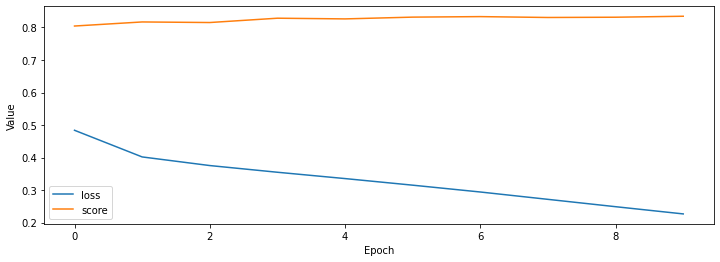

In [28]:
# table
data = {
    'loss': losses,
    'score': scores
}

df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12,4])
plt.plot(losses, label = 'loss')
plt.plot(scores, label = 'score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()